<a href="https://colab.research.google.com/github/sdkchris/Projects/blob/main/Crack_detection_and_localisation_in_wall_images_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly detection

**Definition:**

In his article Ian Cohen defines anomaly detection (aka outlier analysis) as a step in data mining that identifies data points, events, and/or observations that deviate from a dataset’s normal behavior. 

Anomalous data can indicate critical incidents, such as a technical glitch, or potential opportunities, for instance a change in consumer behavior. Nowadays, Machine learning is progressively being used to automate anomaly detection.


**Business problem:** 

The problem that we are trying to solve here is simple. it stems from the Civil engineering/building construction domain. 
Thus, given an image, we want to achieve a dual purpose: 
* Predict the presence of anomalies (cracks)
* And give a colourful representation of the results

**Data Used:**

Source: DataTurks. ML data annotations repository; provides support for Image Annotation, Text and NER Annotation, Video Annotation.

In [ ]:
# import dependencies
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from keras.applications import vgg16
from keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from keras.models import *
from keras.layers import *
from keras import optimizers
from keras.utils import np_utils

from PIL import Image 
import requests
from io import BytesIO
import os
import tqdm
import pickle
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
# Reading the data
data = pd.read_json('/Users/mac/Downloads/crack_classification.json', lines = True)
data['label'] = data.annotation.apply(lambda x: x['labels'][0] if len(x['labels'])==1 else 'Crack')
print (data.shape)
data.head()

(1428, 5)


,content,annotation,extras,metadata,label
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['no Crack'], 'note': ''}",NaN,"{'first_done_at': 1528371420000, 'last_updated...",no Crack
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['Crack'], 'note': ''}",NaN,"{'first_done_at': 1528373761000, 'last_updated...",Crack
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['Crack'], 'note': ''}",NaN,"{'first_done_at': 1528371146000, 'last_updated...",Crack
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['Crack'], 'note': ''}",NaN,"{'first_done_at': 1528371734000, 'last_updated...",Crack
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['no Crack'], 'note': ''}",NaN,"{'first_done_at': 1528372265000, 'last_updated...",no Crack


In [ ]:
# Let's make a get request to read the images, resize and transform them in array format. 
#tdqm shows the progress bar
images = []

for url in tqdm.tqdm(data['content']):
    
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((224, 224))
    numpy_img = img_to_array(img)
    img_batch = np.expand_dims(numpy_img, axis=0)
    images.append(img_batch.astype('float16'))
    
images = np.vstack(images)
print(images.shape)

100%|██████████| 1428/1428 [09:30<00:00,  2.92it/s]


(1428, 224, 224, 3)


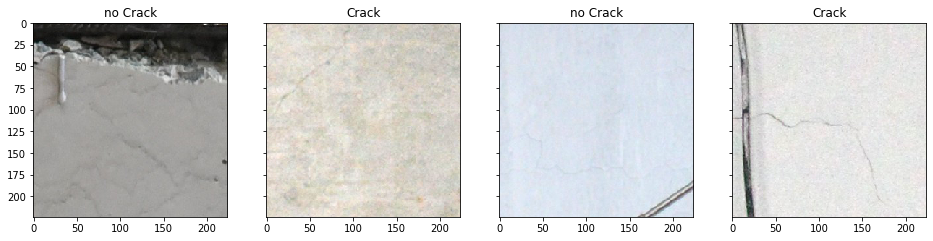

In [ ]:
# Random images plot
random_id = np.random.randint(0,images.shape[0],4)
f, axes = plt.subplots(1,4, sharex=True, sharey=True, figsize=(16,10))

for ax,img,title in zip(axes.ravel(), images[random_id], data['label'][random_id] ):
    ax.imshow(array_to_img(img))
    ax.set_title(title)

From the sample images shown above, notice cracks in image 2 and 4. 
We will use a modified version of the VGG16 Network for this task. VGG16 is a simple and widely used Convolutional Neural Network (CNN) Architecture used for object detection and recognition. 

Main difference with the base model: 
* We use average pooling instead of max pooling in last 2 layers
* Dense layer with softmax activation and output 2 binary values for our task (i.e. crack or no-crack) 

<img src="https://miro.medium.com/max/1400/0*xurYLT8UBpFKPNQA" alt="alt text" title="VGG16 basic architecture" />


In [ ]:
# Importing VGG16

vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

W0908 15:30:48.279660 140735132480256 deprecation_wrapper.py:119] From /Users/mac/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0908 15:30:48.546542 140735132480256 deprecation_wrapper.py:119] From /Users/mac/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0908 15:30:48.593689 140735132480256 deprecation_wrapper.py:119] From /Users/mac/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0908 15:30:48.706687 140735132480256 deprecation_wrapper.py:119] From /Users/mac/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.

58892288/58889256 [==============================] - 149s 3us/step


W0908 15:33:20.539062 140735132480256 deprecation_wrapper.py:119] From /Users/mac/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0908 15:33:20.546834 140735132480256 deprecation_wrapper.py:119] From /Users/mac/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [ ]:
# Freeze the layers except the last 2 convolutional blocks
for layer in vgg_conv.layers[:-8]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x1a3ccf2278> False
<keras.layers.convolutional.Conv2D object at 0x1a3ed5de10> False
<keras.layers.convolutional.Conv2D object at 0x1a3f74ed30> False
<keras.layers.pooling.MaxPooling2D object at 0x1a3f845ac8> False
<keras.layers.convolutional.Conv2D object at 0x1a3f87a9b0> False
<keras.layers.convolutional.Conv2D object at 0x1a3f86a048> False
<keras.layers.pooling.MaxPooling2D object at 0x1a3f871978> False
<keras.layers.convolutional.Conv2D object at 0x1a3f871588> False
<keras.layers.convolutional.Conv2D object at 0x1a3f8b86d8> False
<keras.layers.convolutional.Conv2D object at 0x1a3f8d1e48> False
<keras.layers.pooling.MaxPooling2D object at 0x1a3f8e1e10> False
<keras.layers.convolutional.Conv2D object at 0x1a3f8e1fd0> True
<keras.layers.convolutional.Conv2D object at 0x1a3f9e5940> True
<keras.layers.convolutional.Conv2D object at 0x1a3f9fae10> True
<keras.layers.pooling.MaxPooling2D object at 0x1a3c958198> True
<keras.layers.convolutional

In [ ]:
### ENCODE LABEL ###

Y = np_utils.to_categorical((data.label.values =='Crack')+0)


# Training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(images, Y, random_state= 42, test_size=0.2)

In [ ]:
# Modifying Vgg structure
x = vgg_conv.output
x = GlobalAveragePooling2D()(x)
x = Dense(2, activation='softmax')(x)

model = Model(vgg_conv.input,x)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.0001, momentum=0.9),metrics=['accuracy'])

model.summary()


W0908 15:54:08.355766 140735132480256 deprecation_wrapper.py:119] From /Users/mac/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

At classification stage the GlobalAveragePooling layer was used to reduce the size of the preceding layer by taking the average of each feature map. This choice, plus the omitted usage of intermediate dense layer, permits to avoid overfitting.

Our dense_1 layer is set to 2 (number of features: Crack or no-Crack)

In [ ]:
# Initialize train generetor
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    horizontal_flip = True,
    fill_mode = 'nearest',
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    rotation_range = 30)

In [ ]:
train_datagen.fit(X_train)

In [ ]:
model.fit_generator(train_datagen.flow(X_train, Y_train, batch_size=32), 
                   steps_per_epoch = len(X_train)/32, epochs = 20)

W0908 16:16:26.117511 140735132480256 deprecation.py:323] From /Users/mac/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
36/35 [==============================] - 1119s 31s/step - loss: 0.6859 - acc: 0.5286
Epoch 2/20
36/35 [==============================] - 1073s 30s/step - loss: 0.6358 - acc: 0.7113
Epoch 3/20
36/35 [==============================] - 4763s 132s/step - loss: 0.5909 - acc: 0.7488
Epoch 4/20
36/35 [==============================] - 7250s 201s/step - loss: 0.5266 - acc: 0.7964
Epoch 5/20
36/35 [==============================] - 2452s 68s/step - loss: 0.4618 - acc: 0.8174
Epoch 6/20
36/35 [==============================] - 1173s 33s/step - loss: 0.4123 - acc: 0.8273
Epoch 7/20
36/35 [==============================] - 1193s 33s/step - loss: 0.3589 - acc: 0.8499
Epoch 8/20
36/35 [==============================] - 1117s 31s/step - loss: 0.3290 - acc: 0.8725
Epoch 9/20
36/35 [==============================] - 2690s 75s/step - loss: 0.3492 - acc: 0.8582
Epoch 10/20
36/35 [==============================] - 1175s 33s/step - loss: 0.3401 - acc: 0.8526
Epoch 11/20
36/35 [==================

In [ ]:
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(model.predict(X_test/255),axis = 1)))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       162
           1       0.93      0.85      0.89       124

    accuracy                           0.91       286
   macro avg       0.91      0.90      0.91       286
weighted avg       0.91      0.91      0.91       286



The model is accurate on 91 % of cases

#### confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes, title = "Confusion matrix", cmap=plt.cm.Blues):
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
    plt.title(title, fontsize = 35)
    
    # plt.colorbar
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 15)
        
    plt.ylabel('True label', fontsize = 15)
    plt.xlabel('Predicted label', fontsize = 15)


In [ ]:
conf_matrix = confusion_matrix(np.argmax(Y_test, axis =1), np.argmax(model.predict(X_test/255), axis=1))
plot_confusion_matrix(conf_matrix, classes=df.label.unique(), title="Confusion matrix")
plt.show()

NameError: name 'confusion_matrix' is not defined

We’ve selected the last convolutional layer (‘block5_conv3’) and cut here our classification model. We’ve recreated an intermediate model which, given the original image as input, output the related activation map. 


Thinking about dimensionality, our intermediate model augments the channels (new features) and reduces dimensions (height and width) of our initial image.

In [ ]:
# Let's now draw or plot anomalies on images
def plot_activation(img):
    pred = model.predict(img[np.newaxis,:,:,:])
    pred_class = np.argmax(pred)
    
    weights = model.layers[-1].get_weights()[0]
    class_weights = weights[:, pred_class]
    intermediate = Model(model.input, model.get_layer('block5_conv3').output)
    conv_output = intermediate.predict(img[np.newaxis,:,:,:])
    conv_output = np.squeeze(conv_output)
    
    h = int(img.shape[0] / conv_output.shape[0])
    w = int(img.shape[1] / conv_output.shape[1])
    
    activation_maps = sp.ndimage.zoom(conv_output, (h,w,1), order = 1)
    out = np.dot(activation_maps.reshape((img.shape[0]*img.shape[1], 512)), 
                 class_weights).reshape(img.shape[0],img.shape[1])
    
    plt.imshow(img.astype('float32').reshape(img.shape[0], img.shape[1],3))
    plt.imshow(out,cmap = 'jet',alpha = 0.35)
    plt.title('Crack' if pred_class==1 else 'No Crack')

In the image below, where I’ve plotted the crack heat maps on test images classified as crack. We can see that the heat map is able to generalize well and point pieces of wall containing cracks.

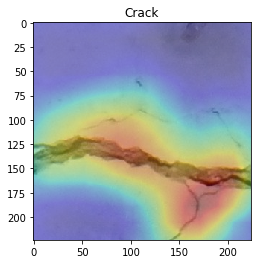

In [ ]:
plot_activation(X_test[150]/255)

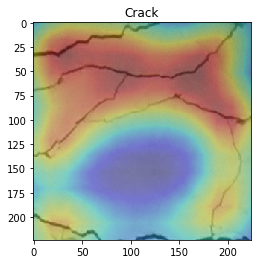

In [ ]:
plot_activation(X_test[0]/255)

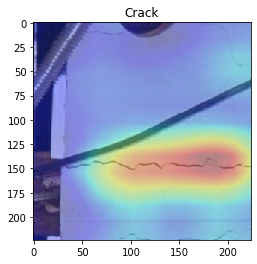

In [ ]:
plot_activation(X_test[10]/255)

**Conclusion:** 
We have successfully learned to detect anomalies (cracks in this case) on walls and the model has helped us visually annotating the anomaluous area of conrcern. This technique can further be improved and applied to other business cases of interest such as: 
* detecting faulty products in manufacturing 
* bumps on vehicle bodies
* crack in bottles on a bottle production line
* etc. 